In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# Import Library
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# input layer
input_h = 28 # Input height
input_w = 28 # Input width
input_ch = 1 # Input channel : Gray scale
# (None, 28, 28, 1)

# First convolution layer
k1_h = 3
k1_w = 3
k1_ch = 32 
p1_h = 2
p1_w = 2
# (None, 14, 14 ,32)

# Second convolution layer
k2_h = 3
k2_w = 3
k2_ch = 64
p2_h = 2
p2_w = 2
# (None, 7, 7 ,64)

## Fully connected: flatten the features -> (None, 7*7*64)
conv_result_size = int(input_h/(p1_h*p2_h)) * int(input_w/(p1_w*p2_w)) * k2_ch
n_hidden = 100
n_output = 10

In [5]:
# kernel size: [kernel_height, kernel_width, input_ch, output_ch]
weights = {
    'conv1' : tf.Variable(tf.random_normal([k1_h, k1_w, input_ch, k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_h, k2_w, k1_ch, k2_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random_normal([conv_result_size, n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_hidden, n_output], stddev = 0.1))
}

# bias size: [output_ch] or [neuron_size]
biases = {
    'conv1' : tf.Variable(tf.random_normal([k1_ch], stddev = 0.1)),
    'conv2' : tf.Variable(tf.random_normal([k2_ch], stddev = 0.1)),
    'hidden' : tf.Variable(tf.random_normal([n_hidden], stddev = 0.1)),
    'output' : tf.Variable(tf.random_normal([n_output], stddev = 0.1))
}

# input layer: [batch_size, image_height, image_width, channels]
# output layer: [batch_size, class_size]
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])
y = tf.placeholder(tf.float32, [None, n_output])

In [6]:
# [batch, height, width, channels]

def net(x, weights, biases):
    # First convolution layer
    conv1 = tf.nn.conv2d(x, 
                         weights['conv1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, 
                           ksize = [1, p1_h, p1_w, 1], 
                           strides = [1, p1_h, p1_w, 1], 
                           padding = 'VALID')
    
    # Second convolution layer
    conv2 = tf.nn.conv2d(maxp1, 
                         weights['conv2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, 
                           ksize = [1, p2_h, p2_w, 1], 
                           strides = [1, p2_h, p2_w, 1], 
                           padding = 'VALID')

    maxp2_flatten = tf.reshape(maxp2, [-1, conv_result_size])
    
    # Fully connected
    hidden = tf.add(tf.matmul(maxp2_flatten, weights['hidden']), biases['hidden'])
    hidden = tf.nn.relu(hidden)
    output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])
    
    return output

In [8]:
LR = 0.0001

pred = net(x, weights, biases)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = pred)
loss = tf.reduce_mean(loss)

optm = tf.train.AdamOptimizer(LR).minimize(loss)

Iter : 0
Cost : 2.475071907043457
Iter : 250
Cost : 0.5005248785018921
Iter : 500
Cost : 0.3925844430923462
Iter : 750
Cost : 0.22938476502895355
Iter : 1000
Cost : 0.09422489255666733
Iter : 1250
Cost : 0.30117806792259216
Iter : 1500
Cost : 0.21393509209156036
Iter : 1750
Cost : 0.09903593361377716
Iter : 2000
Cost : 0.09763070195913315
Iter : 2250
Cost : 0.05192090943455696


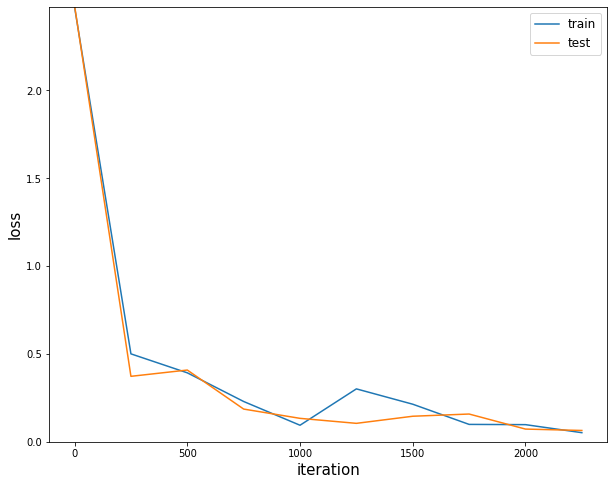

In [9]:
n_batch = 50
n_iter = 2500
n_prt = 250

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

loss_record_train = []
loss_record_test = []
for epoch in range(n_iter):
    train_x, train_y = mnist.train.next_batch(n_batch)
    train_x = np.reshape(train_x, [-1, input_h, input_w, input_ch])
    sess.run(optm, feed_dict = {x: train_x,  y: train_y})
    
    if epoch % n_prt == 0:
        test_x, test_y = mnist.test.next_batch(n_batch)
        test_x = np.reshape(test_x, [-1, input_h, input_w, input_ch])
        c1 = sess.run(loss, feed_dict = {x: train_x, y: train_y})
        c2 = sess.run(loss, feed_dict = {x: test_x, y: test_y})
        loss_record_train.append(c1)
        loss_record_test.append(c2)
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c1))

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label = 'train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, label = 'test')
plt.xlabel('iteration', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

In [10]:
test_x, test_y = mnist.test.next_batch(100)

my_pred = sess.run(pred, feed_dict = {x: test_x.reshape(-1, 28, 28, 1)})
my_pred = np.argmax(my_pred, axis = 1)

labels = np.argmax(test_y, axis = 1)

accr = np.mean(np.equal(my_pred, labels))
print("Accuracy : {}%".format(accr*100))

Accuracy : 95.0%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


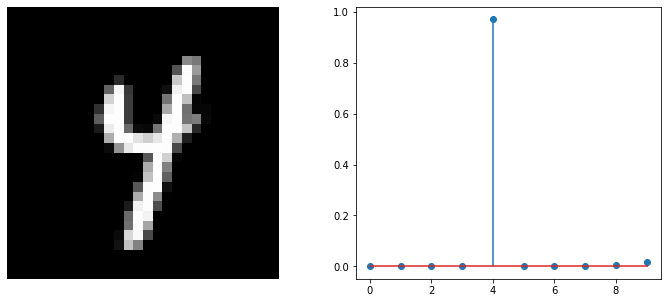

Prediction : 4
Probability : [0.   0.   0.   0.   0.97 0.   0.   0.   0.01 0.02]


In [12]:
test_x, test_y = mnist.test.next_batch(1)
logits = sess.run(tf.nn.softmax(pred), feed_dict = {x: test_x.reshape(-1, 28, 28, 1)})
predict = np.argmax(logits)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.imshow(test_x.reshape(28, 28), 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.stem(logits.ravel())
plt.show()

np.set_printoptions(precision = 2, suppress = True)
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))